# 02- Exploratory Data Analysis (EDA)

In [1]:
import random
import pickle
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk import NaiveBayesClassifier

from gensim.models import Word2Vec

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.manifold import TSNE

In [2]:
df = pd.read_pickle('../data/cleaned_tweets.pkl')

#### count of tweets per region

In [3]:
df.region.value_counts()

india            3274
europe           2399
united states    1088
Name: region, dtype: int64

#### count of tweets per label and region

In [4]:
df.groupby(['label', 'region']).text.count()

label  region       
0      europe           1289
       india            1182
       united states     664
1      europe           1110
       india            2092
       united states     424
Name: text, dtype: int64

#### number of words of a tweet per label per region

In [5]:
df.groupby(['label', 'region']).num_words.mean()

label  region       
0      europe            9.730799
       india            10.448393
       united states     9.963855
1      europe            9.417117
       india            14.498088
       united states    14.224057
Name: num_words, dtype: float64

In [6]:
df.groupby(['label', 'region']).num_words.median()

label  region       
0      europe            9.0
       india             9.0
       united states     9.0
1      europe            9.0
       india            14.0
       united states    12.0
Name: num_words, dtype: float64

#### distribution of number of words in a tweet per true / unreliable category

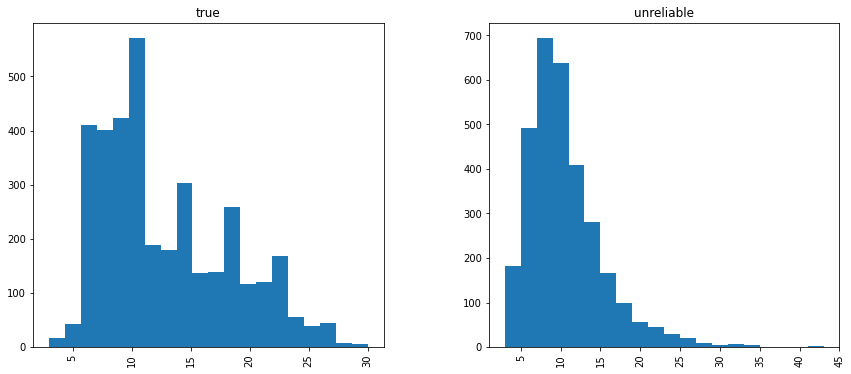

In [7]:
df.num_words.hist(by=df.category, figsize=(14,6), bins=20)
plt.show()


#### count of (non distinct) words in each category

In [8]:
bow_true = []
for word in df[df.category == 'true'].cleaned.str.split().to_list():
    bow_true += word


In [9]:
bow_unreliable = []
for word in df[df.category == 'unreliable'].cleaned.str.split().to_list():
    bow_unreliable += word

In [10]:
len(bow_true)

46814

In [11]:
len(bow_unreliable)

31509

#### most common words in each category

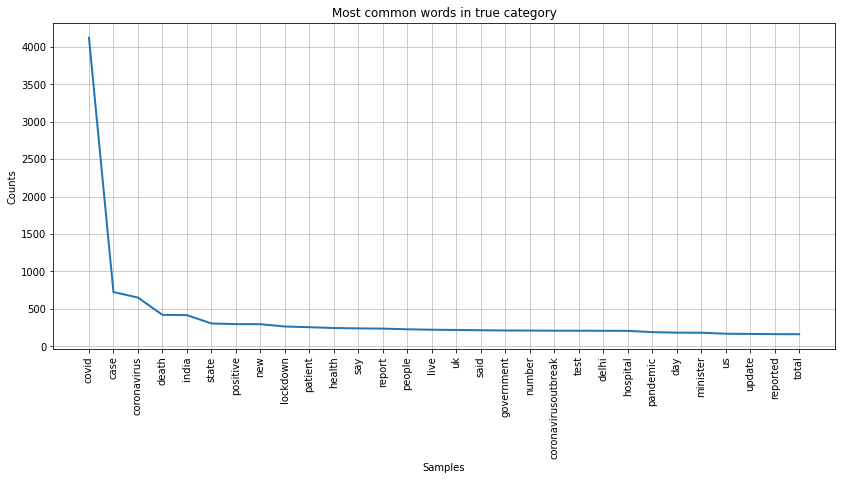

In [12]:
plt.figure(figsize=(14,6))
nltk.FreqDist(bow_true).plot(30,
                             title='Most common words in true category')
plt.show()

In [13]:
Counter(bow_true).most_common(100)

[('covid', 4123),
 ('case', 724),
 ('coronavirus', 650),
 ('death', 419),
 ('india', 415),
 ('state', 304),
 ('positive', 295),
 ('new', 294),
 ('lockdown', 263),
 ('patient', 254),
 ('health', 243),
 ('say', 238),
 ('report', 235),
 ('people', 226),
 ('live', 220),
 ('uk', 217),
 ('said', 213),
 ('government', 210),
 ('number', 209),
 ('coronavirusoutbreak', 207),
 ('test', 207),
 ('delhi', 206),
 ('hospital', 205),
 ('pandemic', 188),
 ('day', 181),
 ('minister', 180),
 ('us', 167),
 ('update', 164),
 ('reported', 161),
 ('total', 160),
 ('tested', 156),
 ('coronaviruscrisis', 149),
 ('watch', 147),
 ('country', 132),
 ('coronaviruspandemic', 129),
 ('one', 127),
 ('may', 125),
 ('spread', 122),
 ('toll', 122),
 ('first', 121),
 ('home', 118),
 ('died', 117),
 ('today', 115),
 ('itvideo', 114),
 ('district', 114),
 ('testing', 111),
 ('maharashtra', 110),
 ('outbreak', 109),
 ('year', 109),
 ('two', 106),
 ('world', 105),
 ('taking', 105),
 ('official', 101),
 ('fight', 101),
 ('cris

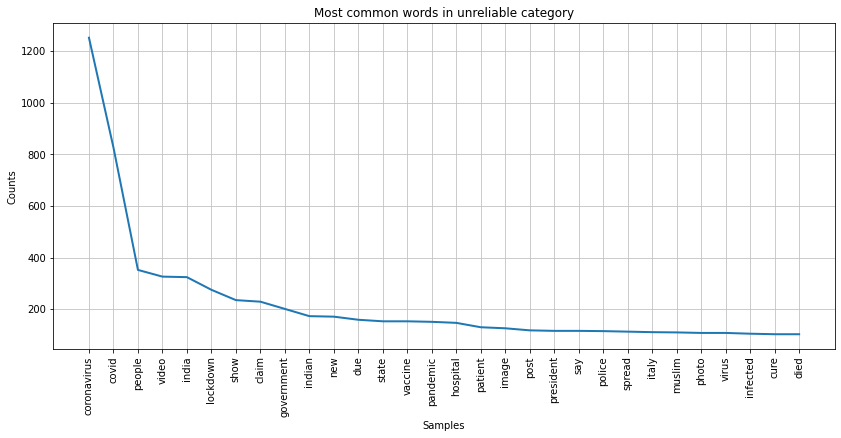

In [14]:
plt.figure(figsize=(14,6))
nltk.FreqDist(bow_unreliable).plot(30,
                             title='Most common words in unreliable category')
plt.show()

In [15]:
Counter(bow_unreliable).most_common(100)

[('coronavirus', 1251),
 ('covid', 826),
 ('people', 352),
 ('video', 326),
 ('india', 324),
 ('lockdown', 275),
 ('show', 235),
 ('claim', 229),
 ('government', 201),
 ('indian', 173),
 ('new', 171),
 ('due', 159),
 ('state', 153),
 ('vaccine', 153),
 ('pandemic', 151),
 ('hospital', 147),
 ('patient', 130),
 ('image', 126),
 ('post', 118),
 ('president', 116),
 ('say', 116),
 ('police', 115),
 ('spread', 113),
 ('italy', 111),
 ('muslim', 110),
 ('photo', 108),
 ('virus', 108),
 ('infected', 105),
 ('cure', 103),
 ('died', 103),
 ('china', 101),
 ('mask', 99),
 ('home', 98),
 ('minister', 97),
 ('doctor', 96),
 ('facebook', 93),
 ('said', 91),
 ('outbreak', 90),
 ('country', 90),
 ('man', 90),
 ('italian', 90),
 ('spain', 87),
 ('novel', 86),
 ('trump', 83),
 ('shared', 83),
 ('death', 82),
 ('health', 81),
 ('social', 79),
 ('bill', 78),
 ('case', 75),
 ('time', 75),
 ('quarantine', 72),
 ('message', 71),
 ('chinese', 70),
 ('gate', 69),
 ('water', 68),
 ('year', 68),
 ('positive', 

#### Word Cloud

In [16]:
wc_true = WordCloud().generate_from_frequencies(nltk.FreqDist(bow_true))
wc_unreliable = WordCloud().generate_from_frequencies(nltk.FreqDist(bow_unreliable))

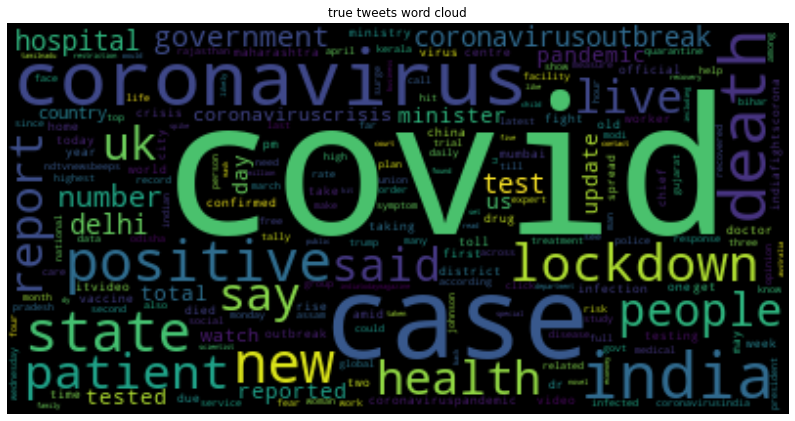

In [17]:
plt.figure(figsize=(14,8))
plt.imshow(wc_true, interpolation='bilinear')
plt.title('true tweets word cloud')
plt.axis('off')
plt.show()

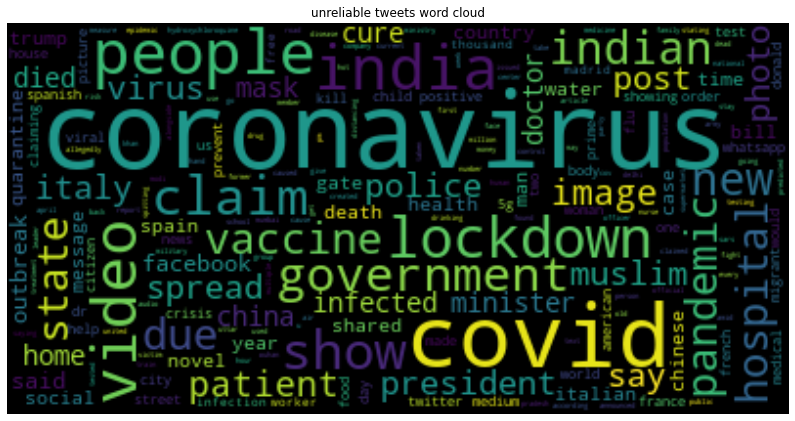

In [18]:
plt.figure(figsize=(14,8))
plt.imshow(wc_unreliable, interpolation='bilinear')
plt.title('unreliable tweets word cloud')
plt.axis('off')
plt.show()

#### size of vocabulary (distinct words)

In [19]:
len(set(bow_true))

7120

In [20]:
len(set(bow_unreliable))

5711

### Naive Bayes for feature importance

In [21]:
texts = [(tweet, cat) for tweet, cat in zip(df.cleaned.str.split().to_list(), df.category.to_list())]

In [22]:
# preview of the first few tuples
texts[:5]

[(['tencent', 'revealed', 'real', 'number', 'death'], 'unreliable'),
 (['taking', 'chlorine', 'dioxide', 'help', 'fight', 'coronavirus'],
  'unreliable'),
 (['video',
   'show',
   'workman',
   'uncovering',
   'bat',
   'infested',
   'roof',
   'us',
   'state',
   'florida'],
  'unreliable'),
 (['asterix',
   'comic',
   'book',
   'simpson',
   'predicted',
   'coronavirus',
   'outbreak'],
  'unreliable'),
 (['chinese',
   'president',
   'xi',
   'jinping',
   'visited',
   'mosque',
   'amid',
   'coronavirus',
   'outbreak',
   'asked',
   'people',
   'muslim',
   'community',
   'pray',
   'present',
   'crisis'],
  'unreliable')]

In [23]:
random.seed(42)
random.shuffle(texts)

In [24]:
words = bow_true + bow_unreliable

In [25]:
freq_word = nltk.FreqDist(words)

In [26]:
top_words = [list(wds) for wds in zip(*freq_word.most_common(2000))][0]

In [27]:
def ext_ft(text,top_words):
    text_set = set(text)
    ft = {}
    for word in top_words:
        ft['word_present({})'.format(word)] = (word in text_set)
    return ft

In [28]:
featuresets = [(ext_ft(text,top_words), cat) for (text,cat) in texts]

In [29]:
train_n = round(len(texts) * 0.8)

In [30]:

train_set, test_set = featuresets[:train_n], featuresets[train_n:]

In [31]:
bayes_clf = nltk.NaiveBayesClassifier.train(train_set)
print(nltk.classify.accuracy(bayes_clf, test_set))

0.9289940828402367


In [32]:
bayes_clf.show_most_informative_features(50)


Most Informative Features
     word_present(total) = True             true : unreli =     70.4 : 1.0
    word_present(update) = True             true : unreli =     44.7 : 1.0
  word_present(whatsapp) = True           unreli : true   =     43.7 : 1.0
  word_present(facebook) = True           unreli : true   =     25.0 : 1.0
      word_present(live) = True             true : unreli =     23.0 : 1.0
   word_present(spanish) = True           unreli : true   =     23.0 : 1.0
      word_present(text) = True           unreli : true   =     22.8 : 1.0
    word_present(monday) = True             true : unreli =     21.0 : 1.0
  word_present(district) = True             true : unreli =     20.8 : 1.0
     word_present(image) = True           unreli : true   =     20.1 : 1.0
      word_present(toll) = True             true : unreli =     20.0 : 1.0
  word_present(recovery) = True             true : unreli =     19.8 : 1.0
 word_present(alongside) = True           unreli : true   =     19.7 : 1.0

### Random Forest Feature Importance

#### Bag of Words (BoW) Classifier

In [33]:
texts =  [(tweet, cat) for tweet, cat in zip(df.cleaned.to_list(), df.category.to_list())]

In [34]:
tweets, labels = (zip(*texts))

In [35]:
count_vectorizer = CountVectorizer(ngram_range=(1,2), max_features=10000)
X = count_vectorizer.fit_transform(tweets)

In [36]:
X_train,X_test,y_train,y_test = train_test_split(X,labels,test_size=0.2,random_state=42)

In [37]:
rf = RandomForestClassifier(n_estimators=100,n_jobs=4,random_state=10)
rf.fit(X_train,y_train)

RandomForestClassifier(n_jobs=4, random_state=10)

In [38]:
y_pred = rf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.9401330376940134


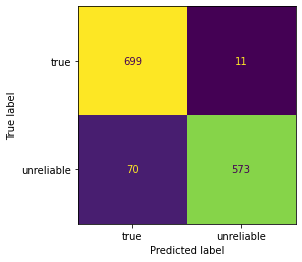

In [39]:
ConfusionMatrixDisplay.from_predictions(
   y_test, y_pred, colorbar=False)
plt.show()


In [40]:
features_list = zip(count_vectorizer.get_feature_names_out(),
                    rf.feature_importances_)
features_list = sorted(features_list, key=lambda x: x[1], reverse=True)

for i in features_list[0:20]:
    print(i)

('covid', 0.2537148017512989)
('coronavirus', 0.0250864142247273)
('video', 0.008150692333370783)
('case', 0.008068692694038222)
('uk', 0.007903777066672994)
('live', 0.007691250494398769)
('covid case', 0.007138086820799378)
('coronavirusoutbreak', 0.0067857678075772705)
('image', 0.005989236716298699)
('watch', 0.00540461034072158)
('italian', 0.005234471184725224)
('indian', 0.004755594297896165)
('photo', 0.004606868461487707)
('claim', 0.004566585393874903)
('people', 0.0043627132671262255)
('show', 0.004059685174116459)
('coronaviruspandemic', 0.0039040333248484224)
('itvideo', 0.003826086162155389)
('death', 0.0038132467123958977)
('update', 0.0037720584646421845)


In [41]:
tfidf = TfidfVectorizer(ngram_range=(1,2),max_features=10000)
X = tfidf.fit_transform(tweets)
X_train,X_test,y_train,y_test = train_test_split(X,labels,test_size=0.2,random_state=42)
rf = RandomForestClassifier(n_estimators=100,n_jobs=4,random_state=10)
rf.fit(X_train,y_train)

RandomForestClassifier(n_jobs=4, random_state=10)

In [42]:
y_pred = rf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.9356984478935698


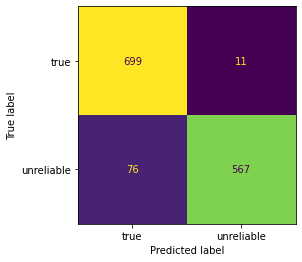

In [43]:
ConfusionMatrixDisplay.from_predictions(
   y_test, y_pred, colorbar=False)
plt.show()


In [44]:
features_list = zip(tfidf.get_feature_names_out(),rf.feature_importances_)
features_list = sorted(features_list, key=lambda x: x[1], reverse=True)

for i in features_list[0:20]:
    print(i)

('covid', 0.2601704700898393)
('coronavirus', 0.031496180346376405)
('video', 0.00927514484647068)
('case', 0.008760932543994446)
('covid case', 0.008181725223467074)
('live', 0.007794790637575876)
('uk', 0.007048032668852466)
('coronavirusoutbreak', 0.00646538041219206)
('people', 0.006265562214666719)
('image', 0.006146404428936686)
('claim', 0.006109219152449351)
('italian', 0.005531559249255754)
('indian', 0.005274499262952034)
('photo', 0.004975346847943869)
('muslim', 0.004249352016140554)
('test', 0.00415342359237544)
('watch', 0.004069714542613557)
('cure', 0.003916340447139033)
('death', 0.0038983478007112893)
('coronaviruscrisis', 0.0038791147425465446)


## Word Embeddings

1. Create a common set of words that exists in both classes
2. Create a word embedding on the true corpus
3. Create a word embedding on the unreliable corpus

In [45]:
true_set = set(bow_true)
unreliable_set = set(bow_unreliable)

In [46]:
common_set = true_set.intersection(unreliable_set)

In [47]:
len(common_set)

2970

In [48]:
Counter(labels)

Counter({'unreliable': 3135, 'true': 3626})

In [49]:
true_tweets = [tweet for tweet, label in zip(tweets, labels) if label == 'true']
true_corpus = [tweet.split() for tweet in true_tweets]

unreliable_tweets = [tweet for tweet, label in zip(tweets, labels) if label == 'unreliable']
unreliable_corpus = [tweet.split() for tweet in unreliable_tweets]
    

In [50]:
# preview
true_corpus[:2]

[['novel', 'coronavirus', 'named', 'covid', 'un', 'health', 'agency', 'afp'],
 ['officially', 'name', 'coronavirus', 'covid', 'coronavirusoutbreak']]

In [51]:
model_true_cbow = Word2Vec(true_corpus, vector_size=300, window=3, min_count=0)
model_true_sg = Word2Vec(true_corpus, sg=1, vector_size=300, window=3, min_count=0)

model_unreliable_cbow = Word2Vec(unreliable_corpus, vector_size=300, window=3, min_count=0)
model_unreliable_sg = Word2Vec(unreliable_corpus,sg=1, vector_size=300, window=3, min_count=0)
# window : int, optional - Maximum distance between the current and predicted word within a sentence.

In [52]:
model_true_cbow.wv.most_similar('covid', topn=20)

[('hospital', 0.9999147653579712),
 ('people', 0.9999116659164429),
 ('us', 0.9999065399169922),
 ('country', 0.9999004602432251),
 ('first', 0.9998959302902222),
 ('lockdown', 0.9998953938484192),
 ('day', 0.9998940825462341),
 ('state', 0.9998922348022461),
 ('testing', 0.999891996383667),
 ('district', 0.9998912811279297),
 ('one', 0.999890923500061),
 ('may', 0.9998890161514282),
 ('say', 0.9998841285705566),
 ('patient', 0.999883234500885),
 ('coronavirus', 0.999882698059082),
 ('government', 0.999882161617279),
 ('said', 0.9998819828033447),
 ('dr', 0.999879777431488),
 ('delhi', 0.9998794198036194),
 ('doctor', 0.9998734593391418)]

In [53]:
model_true_sg.wv.most_similar('covid', topn=20)

[('coronavirus', 0.9972147345542908),
 ('report', 0.9967836141586304),
 ('detected', 0.996008038520813),
 ('india', 0.9959493279457092),
 ('highest', 0.9958178997039795),
 ('day', 0.9958054423332214),
 ('infection', 0.9952825903892517),
 ('two', 0.9952566623687744),
 ('rise', 0.9950107932090759),
 ('fresh', 0.9949880242347717),
 ('active', 0.9947375059127808),
 ('first', 0.9946362972259521),
 ('bihar', 0.994550347328186),
 ('district', 0.9945284128189087),
 ('three', 0.994309663772583),
 ('recorded', 0.9941950440406799),
 ('hour', 0.9941623210906982),
 ('one', 0.993831217288971),
 ('today', 0.9937528967857361),
 ('coronavirusoutbreak', 0.9936808347702026)]

In [54]:
model_unreliable_cbow.wv.most_similar('covid', topn=20)

[('coronavirus', 0.9991453886032104),
 ('people', 0.9989160299301147),
 ('india', 0.9987285137176514),
 ('government', 0.9983635544776917),
 ('state', 0.998347282409668),
 ('hospital', 0.9982641935348511),
 ('lockdown', 0.9982262253761292),
 ('claim', 0.9981915354728699),
 ('virus', 0.9981375336647034),
 ('vaccine', 0.9980566501617432),
 ('muslim', 0.9980483651161194),
 ('doctor', 0.9980341196060181),
 ('italy', 0.9980262517929077),
 ('said', 0.9980195164680481),
 ('mask', 0.9979932904243469),
 ('man', 0.997929036617279),
 ('police', 0.9979103207588196),
 ('indian', 0.9978933930397034),
 ('health', 0.9978853464126587),
 ('day', 0.997833251953125)]

In [55]:
model_unreliable_sg.wv.most_similar('covid', topn=20)

[('coronavirus', 0.9993277192115784),
 ('day', 0.999150812625885),
 ('quarantine', 0.9991449117660522),
 ('people', 0.9991218447685242),
 ('due', 0.9991192817687988),
 ('street', 0.9991132616996765),
 ('virus', 0.9991046786308289),
 ('treatment', 0.9990854859352112),
 ('one', 0.9990513324737549),
 ('help', 0.9990457892417908),
 ('china', 0.9990423917770386),
 ('hospital', 0.9990339279174805),
 ('hour', 0.9990332126617432),
 ('found', 0.999029815196991),
 ('spread', 0.999023973941803),
 ('country', 0.9990206360816956),
 ('disease', 0.9990161657333374),
 ('5g', 0.9990137219429016),
 ('death', 0.999008059501648),
 ('new', 0.9990047812461853)]

In [56]:
model_true_sg.wv.most_similar('trump', topn=20)

[('american', 0.9994366765022278),
 ('working', 0.9994314908981323),
 ('member', 0.9994247555732727),
 ('like', 0.9994211196899414),
 ('challenge', 0.9994094967842102),
 ('would', 0.9994091987609863),
 ('use', 0.999402642250061),
 ('nh', 0.9994001388549805),
 ('condition', 0.9994000792503357),
 ('scientist', 0.999397873878479),
 ('plan', 0.9993929862976074),
 ('must', 0.9993889331817627),
 ('group', 0.9993854761123657),
 ('isolation', 0.9993834495544434),
 ('used', 0.9993830323219299),
 ('stop', 0.999382495880127),
 ('return', 0.9993806481361389),
 ('medicine', 0.9993747472763062),
 ('college', 0.9993703365325928),
 ('held', 0.9993683099746704)]

In [57]:
model_unreliable_sg.wv.most_similar('trump', topn=20)

[('president', 0.9975045323371887),
 ('donald', 0.9959986209869385),
 ('announced', 0.9942158460617065),
 ('u', 0.9941160082817078),
 ('said', 0.9939578175544739),
 ('vice', 0.9938138127326965),
 ('announcing', 0.993639349937439),
 ('macron', 0.9935774803161621),
 ('tweeted', 0.9934165477752686),
 ('us', 0.9933253526687622),
 ('obama', 0.9932870864868164),
 ('tweet', 0.993075430393219),
 ('spain', 0.9930181503295898),
 ('would', 0.9928979277610779),
 ('french', 0.992833137512207),
 ('next', 0.9928179383277893),
 ('left', 0.992817223072052),
 ('testing', 0.9928001165390015),
 ('help', 0.9927986860275269),
 ('three', 0.992721438407898)]

- vector size 300
- each row will denote the word embeddings
- columns will define the value coming from each set
- one from cbow and one from sg
- we need to some type of inference: we need to have a joint word embedding
- test approach by visualizing : take a tweet that's either true or unreliable and project it into the space spanned by the word embeddings: similar to this [blog](https://towardsdatascience.com/tag2image-and-image2tag-joint-representations-for-images-and-text-9ad4e5d0d99)
- - proposal: we have 2 classes and we want to see what are the contextual meaning of the words coming from different classes. how close are these two word embeddings.


[[1,2,3,4,0.5],
 [2, 4, , 67, 7, 7]]

second matrix comes from unreliable

# Hypothetical data structure that needs to be created
np.array([
['common word 1': true:[1,2,3], unreliable:[1,2,3]],
['common word 2': true:[1,2,3], unreliable:[1,2,3]],
['common word 3': true:[1,2,3], unreliable:[1,2,3]],
['common word 4': true:[1,2,3], unreliable:[1,2,3]]
]).shape

In [58]:
common_cbow_model = np.array([[model_true_cbow.wv[word] for word in common_set],
                              [model_unreliable_cbow.wv[word] for word in common_set]
                             ])
common_cbow_model = np.moveaxis(common_cbow_model,0,1)
common_cbow_model.shape

(2970, 2, 300)

In [59]:
common_sg_model = np.array([[model_true_sg.wv[word] for word in common_set],
                              [model_unreliable_sg.wv[word] for word in common_set]
                             ])

common_sg_model = np.moveaxis(common_sg_model,0,1)
common_sg_model.shape

(2970, 2, 300)

### Visualizing Word Embeddings

In [60]:
true_result = TSNE(random_state=42, 
              learning_rate='auto',
              init='random'
              ).fit_transform(common_cbow_model[:,0,])
unreliable_result = TSNE(random_state=42, 
              learning_rate='auto',
              init='random'
              ).fit_transform(common_cbow_model[:,1,])

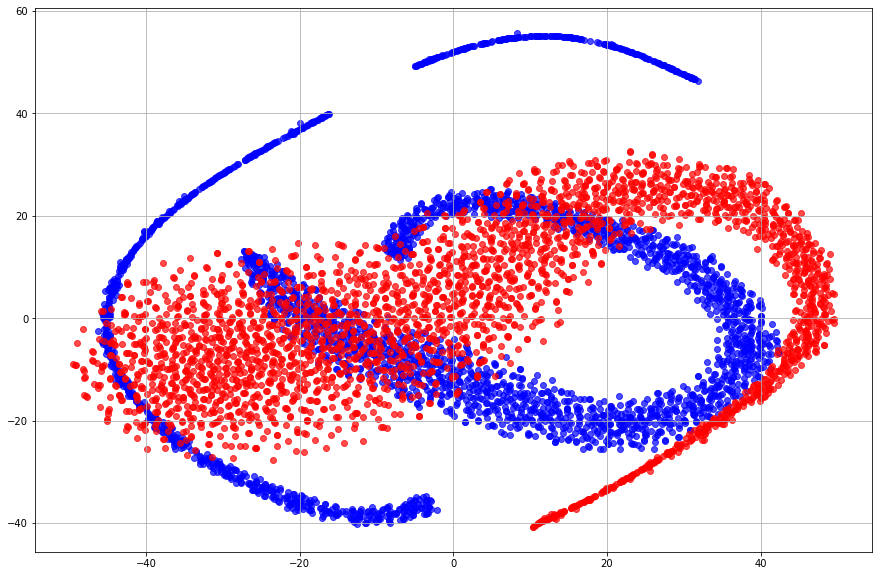

In [61]:
# create a scatter plot of the projection
true_subset = true_result
unreliable_subset = unreliable_result
words = list(common_set)

plt.figure(figsize=(15, 10))
plt.scatter(true_subset[:, 0], true_subset[:, 1], alpha=0.7, c='b')
plt.scatter(unreliable_subset[:, 0], unreliable_subset[:, 1], alpha=0.7, c='r')
# for i, word in enumerate(words):
#     plt.annotate(word, alpha=0.8, xy=(true_subset[i, 0], true_subset[i, 1]), xytext=(5, 2),
#                 textcoords='offset points', ha='right', va='bottom', size=8, color='b')
# for i, word in enumerate(words):
#     plt.annotate(word, alpha=0.8, xy=(unreliable_subset[i, 0], unreliable_subset[i, 1]), xytext=(5, 2),
#                 textcoords='offset points', ha='right', va='bottom', size=8, color='r')
plt.grid(True)
# print(words)
plt.show()

['modified', 'happening', 'lynching', 'vyas', 'recover', 'promising', 'request', 'post', 'streaming', 'badly', 'regime', 'earn', 'leaking', 'bharat', 'escape', 'coalition', 'jaipur', 'plasma', 'prevented', 'comparison', 'everyone', 'synchronized', 'sell', 'spokesman', 'toll', 'death', 'bid', 'note', 'cloud', 'patent']


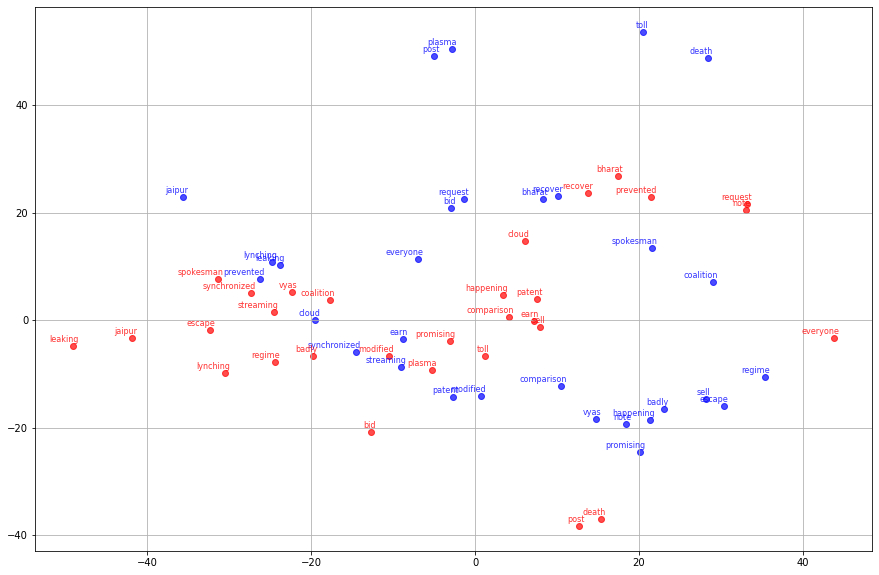

In [62]:
# create a scatter plot of the projection
true_subset = true_result[:30,]
unreliable_subset = unreliable_result[:30,]
words = list(common_set)[:30]

plt.figure(figsize=(15, 10))
plt.scatter(true_subset[:, 0], true_subset[:, 1], alpha=0.7, c='b')
plt.scatter(unreliable_subset[:, 0], unreliable_subset[:, 1], alpha=0.7, c='r')
for i, word in enumerate(words):
    plt.annotate(word, alpha=0.8, xy=(true_subset[i, 0], true_subset[i, 1]), xytext=(5, 2),
                textcoords='offset points', ha='right', va='bottom', size=8, color='b')
for i, word in enumerate(words):
    plt.annotate(word, alpha=0.8, xy=(unreliable_subset[i, 0], unreliable_subset[i, 1]), xytext=(5, 2),
                textcoords='offset points', ha='right', va='bottom', size=8, color='r')
plt.grid(True)
print(words)
plt.show()

In [63]:
true_result = TSNE(random_state=42, 
              learning_rate='auto',
              init='random'
              ).fit_transform(common_sg_model[:,0,])
unreliable_result = TSNE(random_state=42, 
              learning_rate='auto',
              init='random'
              ).fit_transform(common_sg_model[:,1,])

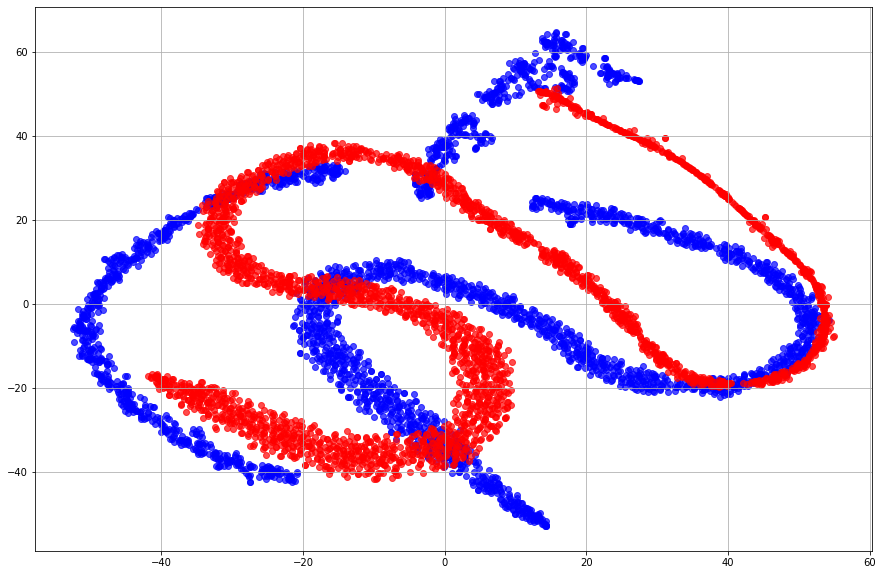

In [64]:
# create a scatter plot of the projection
true_subset = true_result
unreliable_subset = unreliable_result
words = list(common_set)

plt.figure(figsize=(15, 10))
plt.scatter(true_subset[:, 0], true_subset[:, 1], alpha=0.7, c='b')
plt.scatter(unreliable_subset[:, 0], unreliable_subset[:, 1], alpha=0.7, c='r')
# for i, word in enumerate(words):
#     plt.annotate(word, alpha=0.8, xy=(true_subset[i, 0], true_subset[i, 1]), xytext=(5, 2),
#                 textcoords='offset points', ha='right', va='bottom', size=8, color='b')
# for i, word in enumerate(words):
#     plt.annotate(word, alpha=0.8, xy=(unreliable_subset[i, 0], unreliable_subset[i, 1]), xytext=(5, 2),
#                 textcoords='offset points', ha='right', va='bottom', size=8, color='r')
plt.grid(True)
# print(words)
plt.show()

['modified', 'happening', 'lynching', 'vyas', 'recover', 'promising', 'request', 'post', 'streaming', 'badly', 'regime', 'earn', 'leaking', 'bharat', 'escape', 'coalition', 'jaipur', 'plasma', 'prevented', 'comparison', 'everyone', 'synchronized', 'sell', 'spokesman', 'toll', 'death', 'bid', 'note', 'cloud', 'patent']


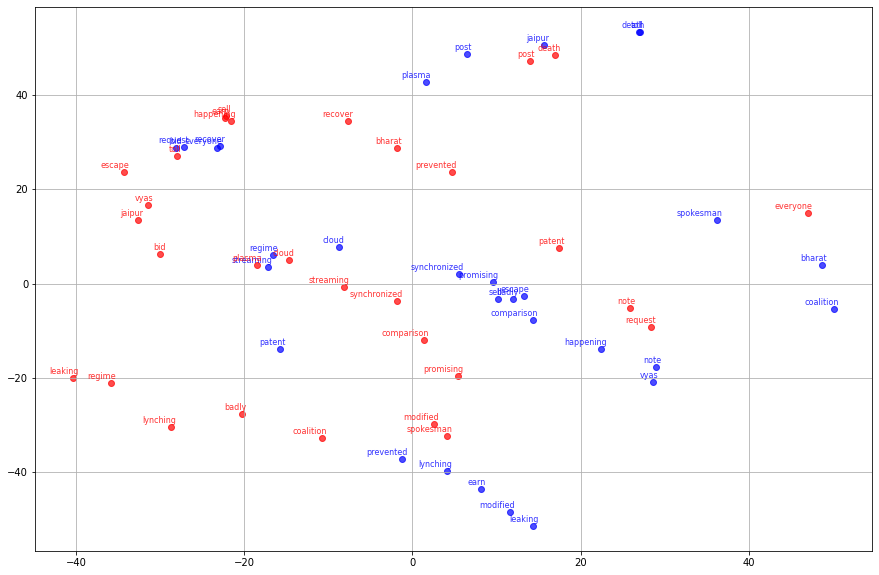

In [65]:
# create a scatter plot of the projection
true_subset = true_result[:30,]
unreliable_subset = unreliable_result[:30,]
words = list(common_set)[:30]

plt.figure(figsize=(15, 10))
plt.scatter(true_subset[:, 0], true_subset[:, 1], alpha=0.7, c='b')
plt.scatter(unreliable_subset[:, 0], unreliable_subset[:, 1], alpha=0.7, c='r')
for i, word in enumerate(words):
    plt.annotate(word, alpha=0.8, xy=(true_subset[i, 0], true_subset[i, 1]), xytext=(5, 2),
                textcoords='offset points', ha='right', va='bottom', size=8, color='b')
for i, word in enumerate(words):
    plt.annotate(word, alpha=0.8, xy=(unreliable_subset[i, 0], unreliable_subset[i, 1]), xytext=(5, 2),
                textcoords='offset points', ha='right', va='bottom', size=8, color='r')
plt.grid(True)
print(words)
plt.show()

Create Maximum pooling of true and false embeddings and represent tweets with the average of that embedding

```py

true:'speak':[1,2,3,1,2,3]
false:'speak':[3,2, 1,5,4,6]

output: max ([],[]) -> [3, 2, 1, 5, 6]

tweet: 3 words: avg([],[],[]) -> tweet representation

What about the words that are not in the common words?
- they get their vector representation from their own embeddings


construct tweet representation: by averaging all the word embeddings for the corresponding words in the tweet

visualize the tweets and apply t-sne dimension reduction and see if you have separation
```

In [66]:
words = list(common_set)

In [67]:
maxs = [np.maximum(common_cbow_model[i][0], common_cbow_model[i][1]) for i in range(len(common_cbow_model))]
common_cbow_max = {}
for word, embedding in [*zip(words, maxs)]:
    common_cbow_max[word] = embedding

maxs = [np.maximum(common_sg_model[i][0], common_sg_model[i][1]) for i in range(len(common_sg_model))]
common_sg_max = {}
for word, embedding in [*zip(words, maxs)]:
    common_sg_max[word] = embedding

In [68]:
uncommon_true_cbow = {word: model_true_cbow.wv[word] for word in true_set if word not in common_set}
uncommon_unreliable_cbow = {word: model_unreliable_cbow.wv[word] for word in unreliable_set if word not in common_set}
uncommon_true_sg = {word: model_true_sg.wv[word] for word in true_set if word not in common_set}
uncommon_unreliable_sg = {word: model_unreliable_sg.wv[word] for word in unreliable_set if word not in common_set}

In [69]:
# we for word embedding
we_true_cbow = uncommon_true_cbow | common_cbow_max
we_unreliable_cbow = uncommon_unreliable_cbow | common_cbow_max
we_true_sg = uncommon_true_sg | common_sg_max
we_unreliable_sg = uncommon_unreliable_sg | common_sg_max

In [70]:
len(we_true_cbow), len(we_unreliable_cbow), len(we_true_sg), len(we_unreliable_sg)

(7120, 5711, 7120, 5711)

In [71]:
def maxi_meaner(word_embedding, tweets):
    tweet_embedding = {}
    for i, tweet in enumerate(tweets):
        tweet_embedding[tweet] = np.mean(np.array([word_embedding[word] for word in tweets[i].split()]), axis=0)
    return tweet_embedding

In [72]:
te_true_cbow = maxi_meaner(we_true_cbow, true_tweets)
te_unreliable_cbow = maxi_meaner(we_unreliable_cbow, unreliable_tweets)
te_true_sg = maxi_meaner(we_true_sg, true_tweets)
te_unreliable_sg = maxi_meaner(we_unreliable_sg, unreliable_tweets)

In [73]:
te_true_cbow_vecs = np.array([v for v in te_true_cbow.values()])
te_unreliable_cbow_vecs = np.array([v for v in te_unreliable_cbow.values()])
te_true_sg_vecs = np.array([v for v in te_true_sg.values()])
te_unreliable_sg_vecs = np.array([v for v in te_unreliable_sg.values()])

In [74]:
true_result = TSNE(random_state=42,
                   learning_rate='auto', init='random').fit_transform(te_true_cbow_vecs)
unreliable_result = TSNE(random_state=42,
                         learning_rate='auto', init='random').fit_transform(te_unreliable_cbow_vecs)

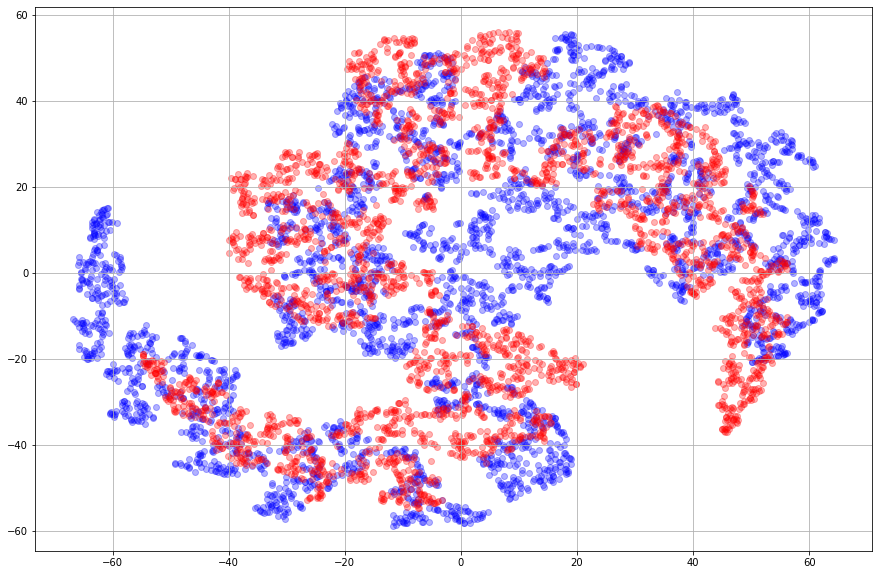

In [75]:

true_subset = true_result
unreliable_subset = unreliable_result

plt.figure(figsize=(15, 10))
plt.scatter(true_subset[:, 0], true_subset[:, 1], alpha=0.3, c='b')
plt.scatter(unreliable_subset[:, 0], unreliable_subset[:, 1], alpha=0.3, c='r')

plt.grid(True)
plt.show()

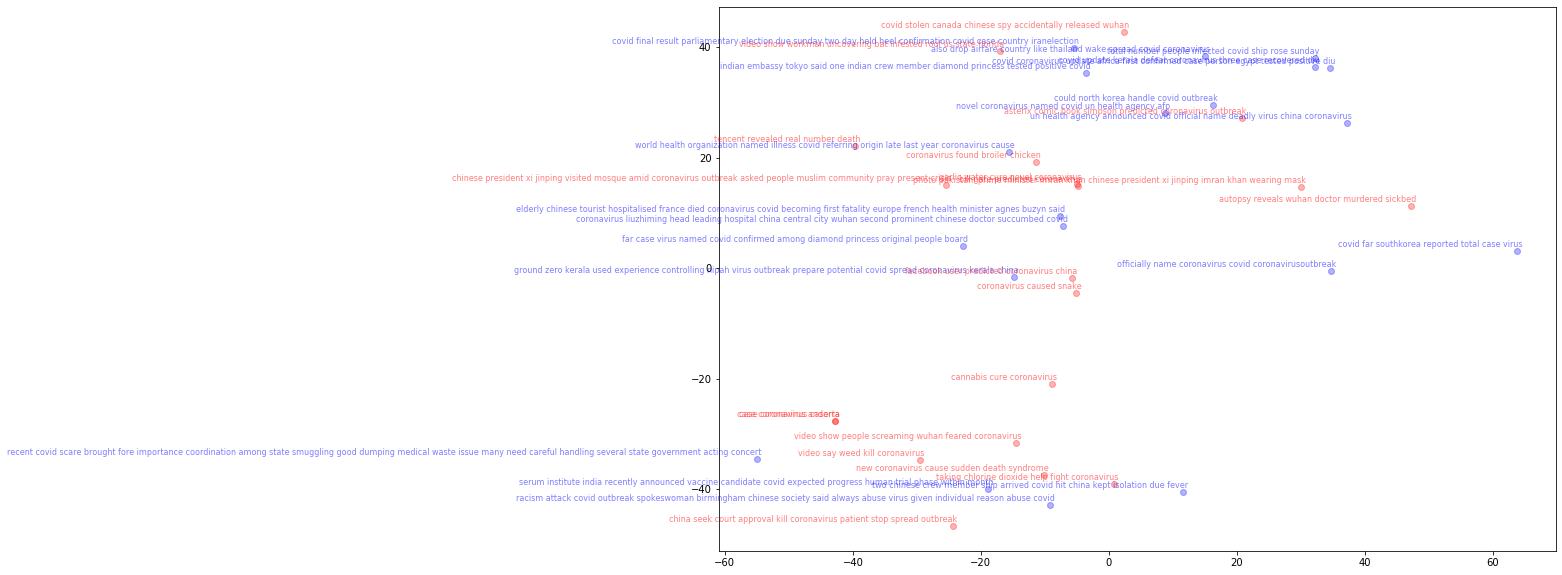

In [76]:
true_subset = true_result[:20,]
unreliable_subset = unreliable_result[:20,]
true_tweet_subset = true_tweets[:20]
unreliable_tweet_subset = unreliable_tweets[:20]

plt.figure(figsize=(15, 10))
plt.scatter(true_subset[:, 0], true_subset[:, 1], alpha=0.3, c='b')
plt.scatter(unreliable_subset[:, 0], unreliable_subset[:, 1], alpha=0.3, c='r')
for i, tweet in enumerate(true_tweet_subset):
    plt.annotate(tweet, alpha=0.5, xy=(true_subset[i, 0], true_subset[i, 1]), xytext=(5, 2),
                textcoords='offset points', ha='right', va='bottom', size=8, color='b')
for i, tweet in enumerate(unreliable_tweet_subset):
    plt.annotate(tweet, alpha=0.5, xy=(unreliable_subset[i, 0], unreliable_subset[i, 1]), xytext=(5, 2),
                textcoords='offset points', ha='right', va='bottom', size=8, color='r')
plt.show()

In [77]:
true_result = TSNE(random_state=42,
                   learning_rate='auto', init='random').fit_transform(te_true_sg_vecs)
unreliable_result = TSNE(random_state=42,
                         learning_rate='auto', init='random').fit_transform(te_unreliable_sg_vecs)

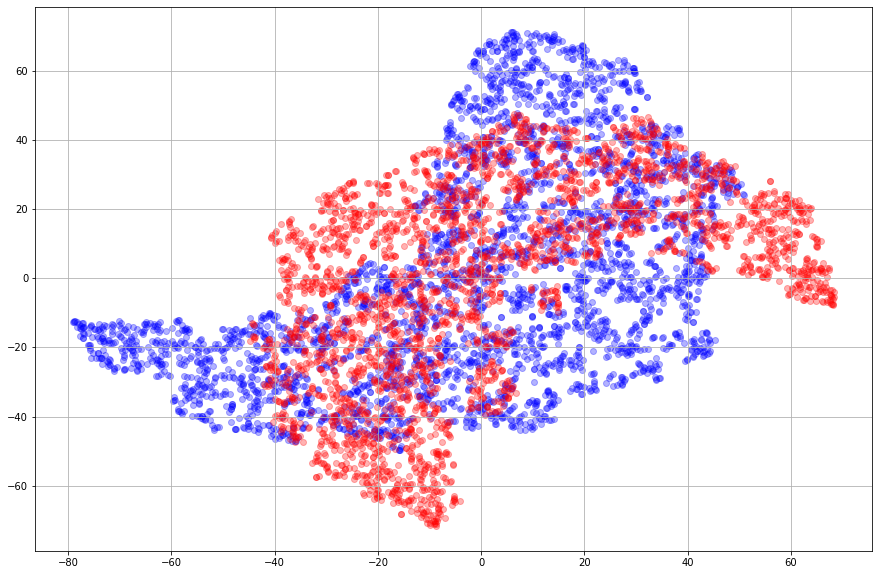

In [78]:
true_subset = true_result
unreliable_subset = unreliable_result

plt.figure(figsize=(15, 10))
plt.scatter(true_subset[:, 0], true_subset[:, 1], alpha=0.3, c='b')
plt.scatter(unreliable_subset[:, 0], unreliable_subset[:, 1], alpha=0.3, c='r')

plt.grid(True)
plt.show()

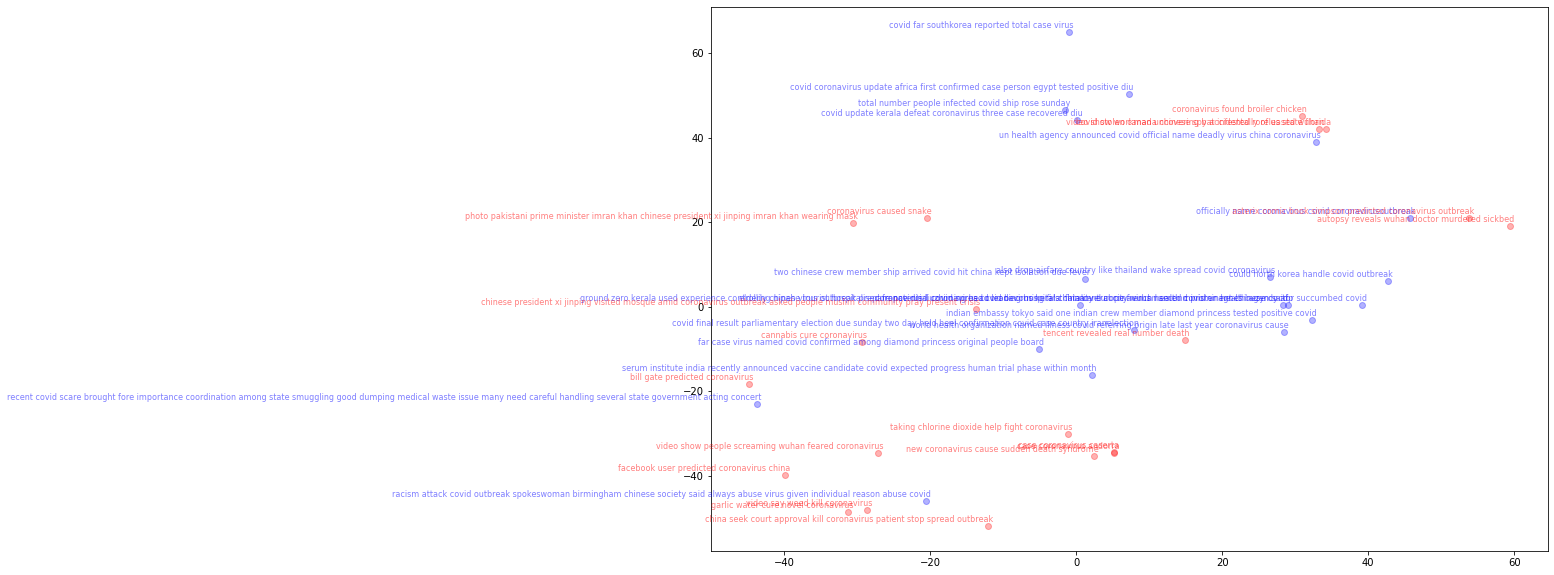

In [79]:
true_subset = true_result[:20,]
unreliable_subset = unreliable_result[:20,]
true_tweet_subset = true_tweets[:20]
unreliable_tweet_subset = unreliable_tweets[:20]

plt.figure(figsize=(15, 10))
plt.scatter(true_subset[:, 0], true_subset[:, 1], alpha=0.3, c='b')
plt.scatter(unreliable_subset[:, 0], unreliable_subset[:, 1], alpha=0.3, c='r')
for i, tweet in enumerate(true_tweet_subset):
    plt.annotate(tweet, alpha=0.5, xy=(true_subset[i, 0], true_subset[i, 1]), xytext=(5, 2),
                textcoords='offset points', ha='right', va='bottom', size=8, color='b')
for i, tweet in enumerate(unreliable_tweet_subset):
    plt.annotate(tweet, alpha=0.5, xy=(unreliable_subset[i, 0], unreliable_subset[i, 1]), xytext=(5, 2),
                textcoords='offset points', ha='right', va='bottom', size=8, color='r')
plt.show()

In [80]:
te_true_cbow_df = pd.DataFrame(te_true_cbow).T.reset_index().rename(columns={'index':'tweet'})
te_true_cbow_df['label'] = 'true'

te_unreliable_cbow_df = pd.DataFrame(te_unreliable_cbow).T.reset_index().rename(columns={'index':'tweet'})
te_unreliable_cbow_df['label'] = 'unreliable'

te_true_sg_df = pd.DataFrame(te_true_sg).T.reset_index().rename(columns={'index':'tweet'})
te_true_sg_df['label'] = 'true'

te_unreliable_sg_df = pd.DataFrame(te_unreliable_sg).T.reset_index().rename(columns={'index':'tweet'})
te_unreliable_sg_df['label'] = 'unreliable'

In [82]:
te_cbow_df = pd.concat([te_true_cbow_df, te_unreliable_cbow_df])
te_sg_df = pd.concat([te_true_sg_df, te_unreliable_sg_df])

In [83]:
pickle.dump(te_cbow_df, open("../data/te_cbow_df_training.pickle", "wb"))
pickle.dump(te_sg_df, open("../data/te_sg_df_training.pickle", "wb"))

In [84]:
training_words_set = (true_set | unreliable_set)

In [85]:
pickle.dump(training_words_set, open("../data/training_words_set.pickle", "wb"))